In [1]:
# The MIT License (MIT) Copyright (c) 2023 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/24_CNN.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

In [3]:
torch.manual_seed(77)

# Red nauronal convolucional 

## 1.- Pipeline

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

batch_size = 64

train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_batch, target_batch = next(iter(train_loader))

In [6]:
train_batch.shape, target_batch.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

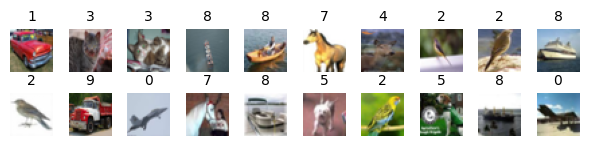

In [7]:
# Define a function to plot images with titles
def plot_batch(images, labels):
    fig, axes = plt.subplots(2, 10, figsize=(6, 1.5))
    axes = axes.flatten()

    for i in range(len(images)):
        axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].set_title(labels[i].numpy(), fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Select a batch of images and their corresponding targets
n = 20
batch_images = train_batch[:n]
batch_labels = target_batch[:n]

# Plot the batch of images
plot_batch(batch_images, batch_labels)

## 2.- Modelo

In [8]:
import torch.nn as nn
from torch import optim
import time

In [9]:
cnn = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(8 * 8 * 32, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [10]:
cnn(train_batch).shape

torch.Size([64, 10])

In [11]:
from torchsummary import summary

In [12]:
summary(cnn, train_batch.shape[1:], device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 16, 16]          448
├─ReLU: 1-2                              [-1, 16, 16, 16]          --
├─Conv2d: 1-3                            [-1, 32, 8, 8]            4,640
├─ReLU: 1-4                              [-1, 32, 8, 8]            --
├─Flatten: 1-5                           [-1, 2048]                --
├─Linear: 1-6                            [-1, 256]                 524,544
├─ReLU: 1-7                              [-1, 256]                 --
├─Linear: 1-8                            [-1, 10]                  2,570
Total params: 532,202
Trainable params: 532,202
Non-trainable params: 0
Total mult-adds (M): 0.93
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 2.03
Estimated Total Size (MB): 2.09


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 16, 16]          448
├─ReLU: 1-2                              [-1, 16, 16, 16]          --
├─Conv2d: 1-3                            [-1, 32, 8, 8]            4,640
├─ReLU: 1-4                              [-1, 32, 8, 8]            --
├─Flatten: 1-5                           [-1, 2048]                --
├─Linear: 1-6                            [-1, 256]                 524,544
├─ReLU: 1-7                              [-1, 256]                 --
├─Linear: 1-8                            [-1, 10]                  2,570
Total params: 532,202
Trainable params: 532,202
Non-trainable params: 0
Total mult-adds (M): 0.93
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 2.03
Estimated Total Size (MB): 2.09

## 3.- Entrenamiento

In [13]:
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [14]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [15]:
def test(model, device, test_loader):
    start = time.time()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = loss_fn(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            running_acc += (pred == labels).sum().item()
            running_loss += loss.item()

    print(f'Time for eval is {time.time()-start:.4f} sec Val loss: {running_loss / len(test_loader):.4f}')
    print(f'Val acc: {running_acc / len(test_loader.dataset):.4f}')

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [17]:
cnn.to(device)

optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [18]:
epochs = 7

for epoch in range(epochs):
    train(cnn, device, train_loader, optimizer, epoch)
    test(cnn, device, val_loader)


Time for epoch 0 is 2.3272 sec Train loss: 1.6381
Time for eval is 0.4869 sec Val loss: 1.4103
Val acc: 0.4912

Time for epoch 1 is 2.1396 sec Train loss: 1.3480
Time for eval is 0.4843 sec Val loss: 1.2797
Val acc: 0.5466

Time for epoch 2 is 2.1519 sec Train loss: 1.2225
Time for eval is 0.5005 sec Val loss: 1.2035
Val acc: 0.5706

Time for epoch 3 is 2.1701 sec Train loss: 1.1296
Time for eval is 0.4683 sec Val loss: 1.1447
Val acc: 0.5938

Time for epoch 4 is 2.2015 sec Train loss: 1.0518
Time for eval is 0.4807 sec Val loss: 1.1247
Val acc: 0.5972

Time for epoch 5 is 2.2370 sec Train loss: 0.9753
Time for eval is 0.4819 sec Val loss: 1.0995
Val acc: 0.6102

Time for epoch 6 is 2.1874 sec Train loss: 0.9040
Time for eval is 0.4709 sec Val loss: 1.1019
Val acc: 0.6165


- Modelo con normalización de lotes

In [19]:
cnn_bn = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(8 * 8 * 32, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [20]:
cnn_bn(train_batch).shape

torch.Size([64, 10])

In [21]:
summary(cnn_bn, train_batch.shape[1:], device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 16, 16]          448
├─BatchNorm2d: 1-2                       [-1, 16, 16, 16]          32
├─ReLU: 1-3                              [-1, 16, 16, 16]          --
├─Conv2d: 1-4                            [-1, 32, 8, 8]            4,640
├─BatchNorm2d: 1-5                       [-1, 32, 8, 8]            64
├─ReLU: 1-6                              [-1, 32, 8, 8]            --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 256]                 524,544
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 532,298
Trainable params: 532,298
Non-trainable params: 0
Total mult-adds (M): 0.93
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 2.03
Estimated Total Size (MB): 2.14


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 16, 16]          448
├─BatchNorm2d: 1-2                       [-1, 16, 16, 16]          32
├─ReLU: 1-3                              [-1, 16, 16, 16]          --
├─Conv2d: 1-4                            [-1, 32, 8, 8]            4,640
├─BatchNorm2d: 1-5                       [-1, 32, 8, 8]            64
├─ReLU: 1-6                              [-1, 32, 8, 8]            --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 256]                 524,544
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 532,298
Trainable params: 532,298
Non-trainable params: 0
Total mult-adds (M): 0.93
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 2.03
Estimated Total Size (MB): 2.14

In [22]:
cnn_bn.to(device)

optimizer_bn = optim.Adam(cnn_bn.parameters(), lr=0.001)

In [23]:
epochs = 7

for epoch in range(epochs):
    train(cnn_bn, device, train_loader, optimizer_bn, epoch)
    test(cnn_bn, device, val_loader)


Time for epoch 0 is 2.2503 sec Train loss: 1.3875
Time for eval is 0.4883 sec Val loss: 1.2549
Val acc: 0.5472

Time for epoch 1 is 2.1337 sec Train loss: 1.0583
Time for eval is 0.4768 sec Val loss: 1.1522
Val acc: 0.5843

Time for epoch 2 is 2.1338 sec Train loss: 0.8933
Time for eval is 0.4481 sec Val loss: 1.2981
Val acc: 0.5689

Time for epoch 3 is 2.0848 sec Train loss: 0.7630
Time for eval is 0.4772 sec Val loss: 0.9946
Val acc: 0.6542

Time for epoch 4 is 2.1753 sec Train loss: 0.6446
Time for eval is 0.4940 sec Val loss: 1.0011
Val acc: 0.6631

Time for epoch 5 is 2.2546 sec Train loss: 0.5334
Time for eval is 0.5058 sec Val loss: 1.1561
Val acc: 0.6395

Time for epoch 6 is 2.2593 sec Train loss: 0.4324
Time for eval is 0.4934 sec Val loss: 1.2414
Val acc: 0.6398


## Ejercicio
- Modificar la arquitectura y el entrenamiento para obtener mejores resultados.